In [37]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS

In [38]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP.bart import BART

In [39]:
Carseats = load_data('Carseats')
High = np.where(Carseats.Sales > 8,
                "Yes",
                "No")
Carseats

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


In [40]:
model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)

C:\Users\jason\anaconda3\lib\site-packages\ISLP\models\columns.py:151: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if is_categorical[i]:
C:\Users\jason\anaconda3\lib\site-packages\ISLP\models\columns.py:151: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if is_categorical[i]:
C:\Users\jason\anaconda3\lib\site-packages\ISLP\models\columns.py:151: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if is_categorical[i]:
C:\Users\jason\anac

In [41]:
# clf = DTC(criterion='entropy',
#           max_depth=3,
#           random_state=0)        
# clf.fit(X, High)

clf = DTC(criterion = 'entropy', max_depth = 3, random_state = 0)
clf.fit(X, High)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [42]:
accuracy_score(High, clf.predict(X))


0.79

In [43]:
resid_dev = np.sum(log_loss(High, clf.predict_proba(X)))
resid_dev

0.47106470626493574

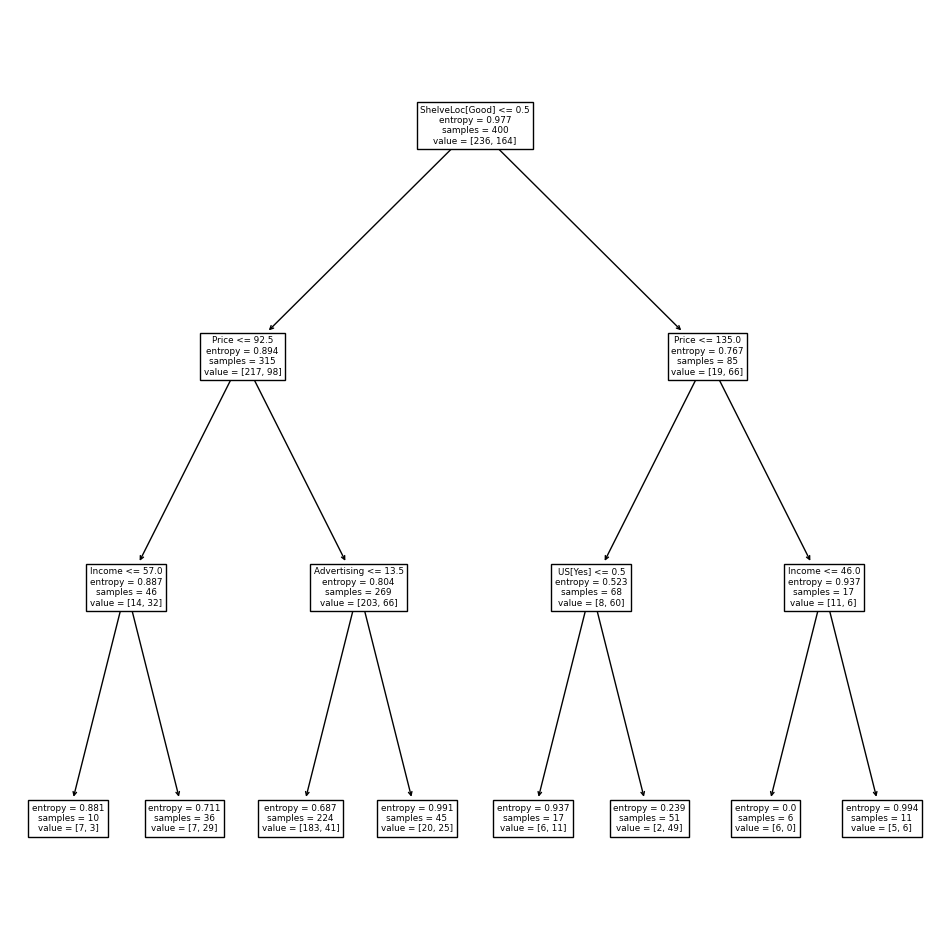

In [44]:
ax = subplots(figsize=(12,12))[1]
plot_tree(clf,
          feature_names=feature_names,
          ax=ax);

In [45]:
print(export_text(clf,
                  feature_names=feature_names,
                  show_weights=True))

|--- ShelveLoc[Good] <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- weights: [7.00, 3.00] class: No
|   |   |--- Income >  57.00
|   |   |   |--- weights: [7.00, 29.00] class: Yes
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- weights: [183.00, 41.00] class: No
|   |   |--- Advertising >  13.50
|   |   |   |--- weights: [20.00, 25.00] class: Yes
|--- ShelveLoc[Good] >  0.50
|   |--- Price <= 135.00
|   |   |--- US[Yes] <= 0.50
|   |   |   |--- weights: [6.00, 11.00] class: Yes
|   |   |--- US[Yes] >  0.50
|   |   |   |--- weights: [2.00, 49.00] class: Yes
|   |--- Price >  135.00
|   |   |--- Income <= 46.00
|   |   |   |--- weights: [6.00, 0.00] class: No
|   |   |--- Income >  46.00
|   |   |   |--- weights: [5.00, 6.00] class: Yes



In [46]:
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=200,
                              random_state=0)
results = skm.cross_validate(clf,
                             D,
                             High,
                             cv=validation)
results['test_score']

array([0.685])

In [47]:
(X_train,
 X_test,
 High_train,
 High_test) = skm.train_test_split(X,
                                   High,
                                   test_size=0.5,
                                   random_state=0)

In [48]:
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train, High_train)
accuracy_score(High_test, clf.predict(X_test))

0.735

In [49]:
ccp_path = clf.cost_complexity_pruning_path(X_train, High_train)
kfold = skm.KFold(10,
                  random_state=1,
                  shuffle=True)


In [50]:
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, High_train)
grid.best_score_

0.685

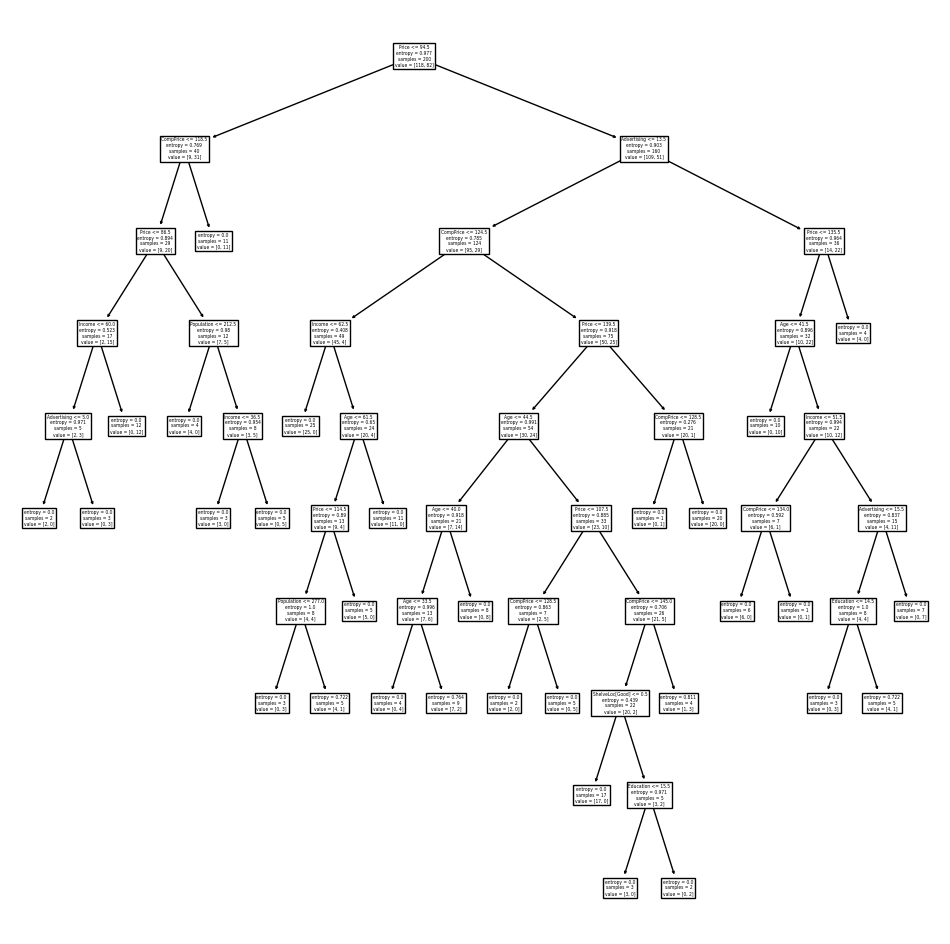

In [51]:
ax = subplots(figsize=(12, 12))[1]
best_ = grid.best_estimator_
plot_tree(best_,
          feature_names=feature_names,
          ax=ax);

In [52]:
best_.tree_.n_leaves


30

In [53]:
print(accuracy_score(High_test,
                     best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),
                            High_test)
confusion

0.72


Truth,No,Yes
Predicted,,
No,94,32
Yes,24,50


In [54]:
Boston = load_data("Boston")
model = MS(Boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

C:\Users\jason\anaconda3\lib\site-packages\ISLP\models\columns.py:151: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if is_categorical[i]:
C:\Users\jason\anaconda3\lib\site-packages\ISLP\models\columns.py:151: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if is_categorical[i]:
C:\Users\jason\anaconda3\lib\site-packages\ISLP\models\columns.py:151: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if is_categorical[i]:
C:\Users\jason\anac

In [55]:
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                Boston['medv'],
                                test_size=0.3,
                                random_state=0)

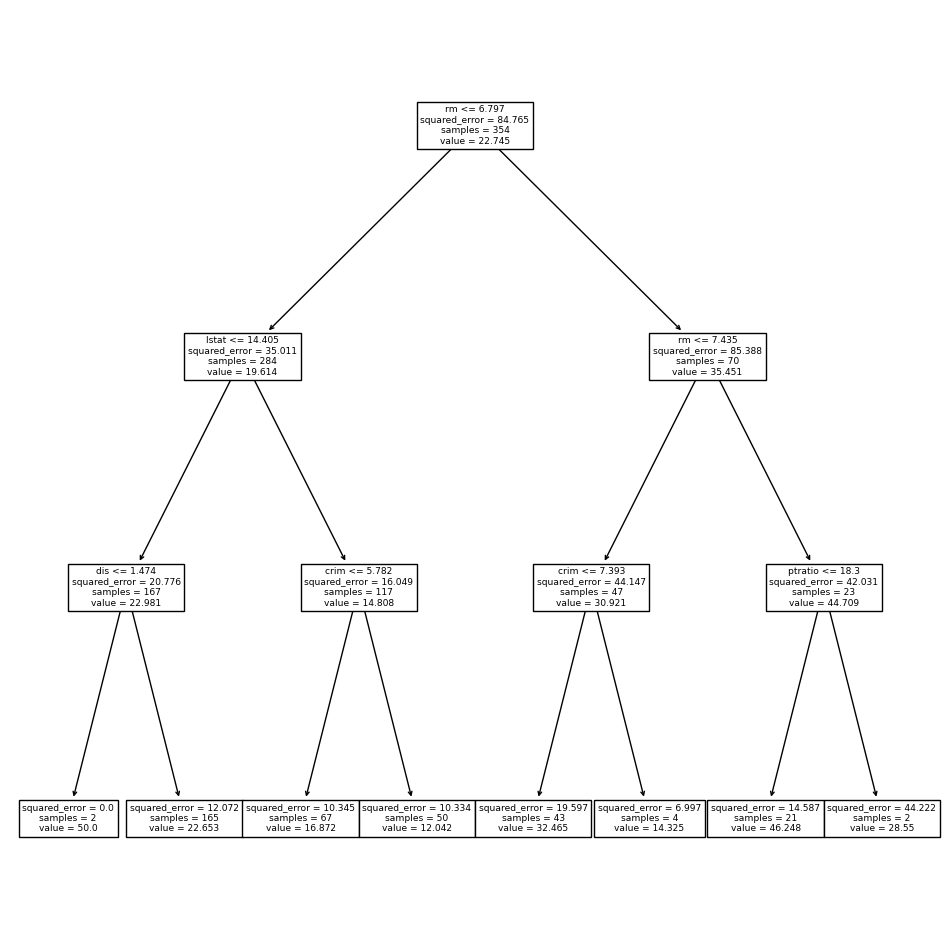

In [56]:
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax);

In [57]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)


In [58]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

28.06985754975404

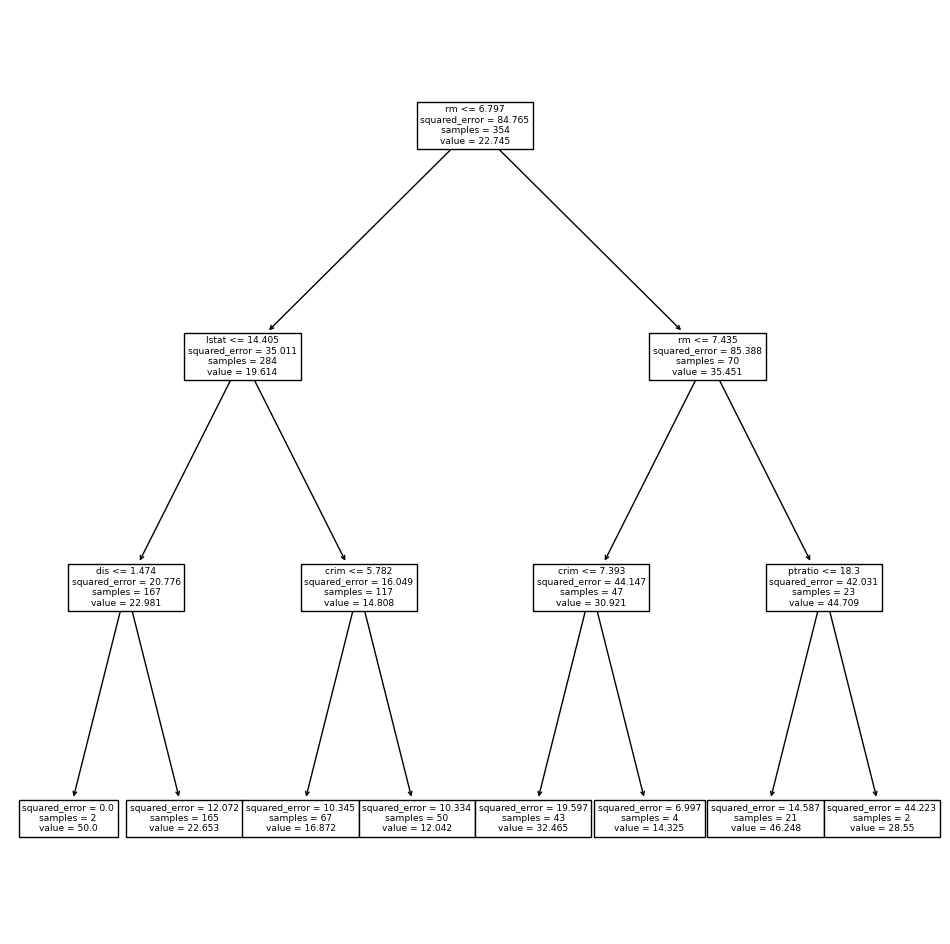

In [59]:
ax = subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_,
          feature_names=feature_names,
          ax=ax);

In [60]:
bag_boston = RF(max_features=X_train.shape[1], random_state=0)
bag_boston.fit(X_train, y_train)

RandomForestRegressor(max_features=12, random_state=0)

14.634700151315787

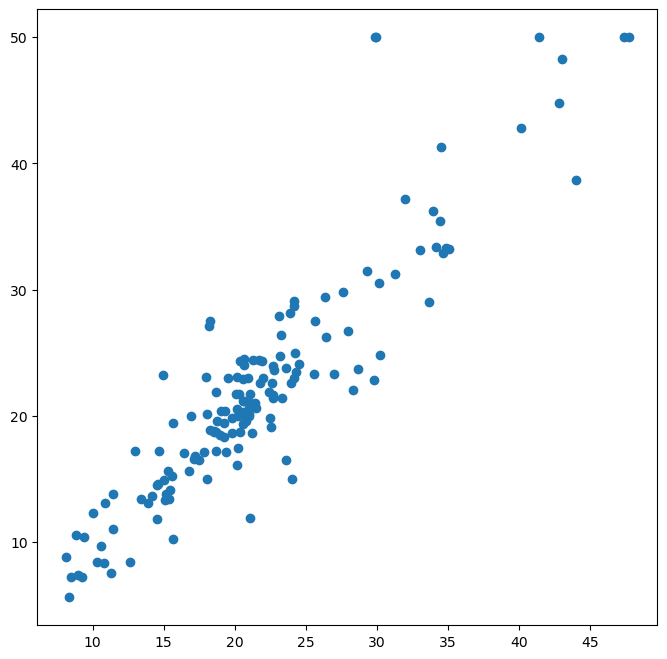

In [61]:
ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_boston.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)

In [62]:
bag_boston = RF(max_features=X_train.shape[1],
                n_estimators=500,
                random_state=0).fit(X_train, y_train)
y_hat_bag = bag_boston.predict(X_test)
np.mean((y_test - y_hat_bag)**2)

14.605662565263161

In [63]:
RF_boston = RF(max_features=6,
               random_state=0).fit(X_train, y_train)
y_hat_RF = RF_boston.predict(X_test)
np.mean((y_test - y_hat_RF)**2)

20.04276446710527

In [64]:
feature_imp = pd.DataFrame(
    {'importance':RF_boston.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
lstat,0.356203
rm,0.332163
ptratio,0.067270
crim,0.055404
indus,0.053851
dis,0.041582
nox,0.035225
tax,0.025355
age,0.021506
rad,0.004784


In [65]:
boost_boston = GBR(n_estimators=5000,
                   learning_rate=0.001,
                   max_depth=3,
                   random_state=0)
boost_boston.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000,
                          random_state=0)

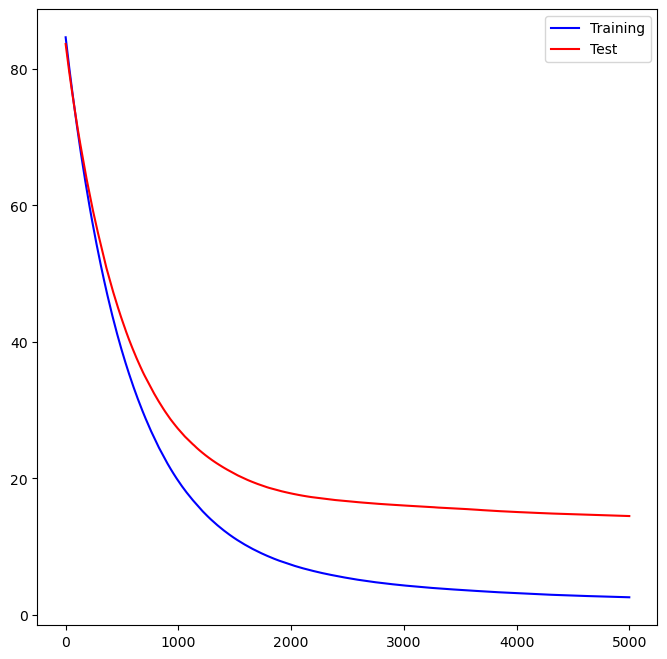

In [66]:
test_error = np.zeros_like(boost_boston.train_score_)
for idx, y_ in enumerate(boost_boston.staged_predict(X_test)):
   test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(boost_boston.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx,
        boost_boston.train_score_,
        'b',
        label='Training')
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test')
ax.legend();

In [67]:
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)


14.481405918831591

In [68]:
boost_boston = GBR(n_estimators=5000,
                   learning_rate=0.2,
                   max_depth=3,
                   random_state=0)
boost_boston.fit(X_train,
                 y_train)
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)

14.501514553719565

In [69]:
bart_boston = BART(random_state=0, burnin=5, ndraw=15)
bart_boston.fit(X_train, y_train)

ValueError: high is out of bounds for int32

In [ ]:
yhat_test = bart_boston.predict(X_test.astype(np.float32))
np.mean((y_test - yhat_test)**2)

In [ ]:
var_inclusion = pd.Series(bart_boston.variable_inclusion_.mean(0),
                               index=D.columns)
var_inclusion

#1
A) Best subset selection will have the lowest RSS cause it considers every possible subset of predictors to find the one with the lowest RSS.
B) It is unsure because best subset may overfit and the others may just do better by luck
C) 
    i) This is true because if the K+1 model doesn't choose to include the k+1th predictor, it is the same as a K predictor model. 
    ii) This is true because if the K+1 model doesn't choose to include the k+1th predictor, it is the same as a K predictor model. 
    iii) I feel like this isn't true because the forward stepwise and backwards stepwise go in the oppisite direction and that can mess it up. But I am not sure
    iv) I feel like this isn't true because the forward stepwise and backwards stepwise go in the oppisite direction and that can mess it up. But I am not sure
    v) True because best subset has every possible set of predictors and backwards stepwise only has a portion of possible predictors

#3 
A) It will steadily decrease because there is a true B that fits the model best and minimizes the RSS. It is restricted to 0 at first so it has a large RSS and then it will eventually get to the Best B
B) The RSS will decrease at first as it is at 0 and a huge RSS. Then once the B reaches its true value, it will minimize the error. But then it will increase due to error in the training model
C) Variance will increase because the model is inflexible at first and then becomes more flexible
D) Bias will decrease as the model becomes more flexible and accurate.
E) The irreducuble will stay the same because it can't be changed
